In [1]:
import cv2
import numpy as np
import json
import os
import argparse

import torch
import segmentation_models_pytorch as smp

from src.data_loader import get_test_data_loaders
from src import utils

import matplotlib.pyplot as plt

In [2]:

class_color_maps = {'0': (0, 0, 0), # background -> black
 '1': (234, 155, 162),
 '2': (211, 78, 67),
 '3': (237, 231, 159),
 '4': (145, 209, 61),
 '5': (137, 193, 198),
 '6': (27, 230, 195),
 '7': (52, 138, 174),
 '8': (216, 86, 141),
 '9': (243, 157, 207),
 '10': (118, 176, 70),
 '11': (238, 173, 77),
 '12': (205, 219, 90),
 '13': (43, 56, 153)}



# Define the number of classes
num_classes = len(class_color_maps)

# Define a function to annotate the classes in the ground truth
def annotate_classes(mask):
    # Create an output image with the same shape as the input mask
    h, w = mask.shape[:2]
    output = np.zeros((h, w, 3), dtype=np.uint8)

    for class_, color in class_color_maps.items():
        output[mask == int(class_)] = color

    return output

def show_imgs(x,y,y_pred):
    n = x.shape[0]
    
    fig, ax = plt.subplots(n, 3, figsize=(3*5, n*5))

    for i, (img, mask, mask_pred) in enumerate(zip(x,y,y_pred)):
        ax[i][0].imshow(img.permute(1,2,0))
        ax[i][1].imshow(annotate_classes(mask))
        ax[i][2].imshow(annotate_classes(mask_pred))


In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

args = {
   "model_path": "./checkpoints/checkpoint_4/model.pth",
   "smp_configs_path": "./checkpoints/checkpoint_9/smp_configs.json",
   "input_dir": "./data/test_images/",
   "output_dir": "./data/preds/",
}


In [4]:
with open(os.path.join(args['smp_configs_path'])) as f:
    model_configs = json.load(f)

model = smp.Unet(
    encoder_name=model_configs['encoder'],
    encoder_weights='imagenet',
    in_channels=3,
    classes=14
)
model.load_state_dict(torch.load(args['model_path']))

test_dl = get_test_data_loaders(args['input_dir'])

model.to(device)

['test_0000.png', 'test_0001.png', 'test_0002.png', 'test_0003.png', 'test_0004.png', 'test_0005.png', 'test_0006.png', 'test_0007.png', 'test_0008.png', 'test_0009.png', 'test_0010.png']


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

0
1
2
3
4
5
6
7
8
9
10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving predicted mask #0
saving predicted mask #1
saving predicted mask #2
saving predicted mask #3
saving predicted mask #4
saving predicted mask #5
saving predicted mask #6
saving predicted mask #7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving predicted mask #8
saving predicted mask #9
saving predicted mask #10


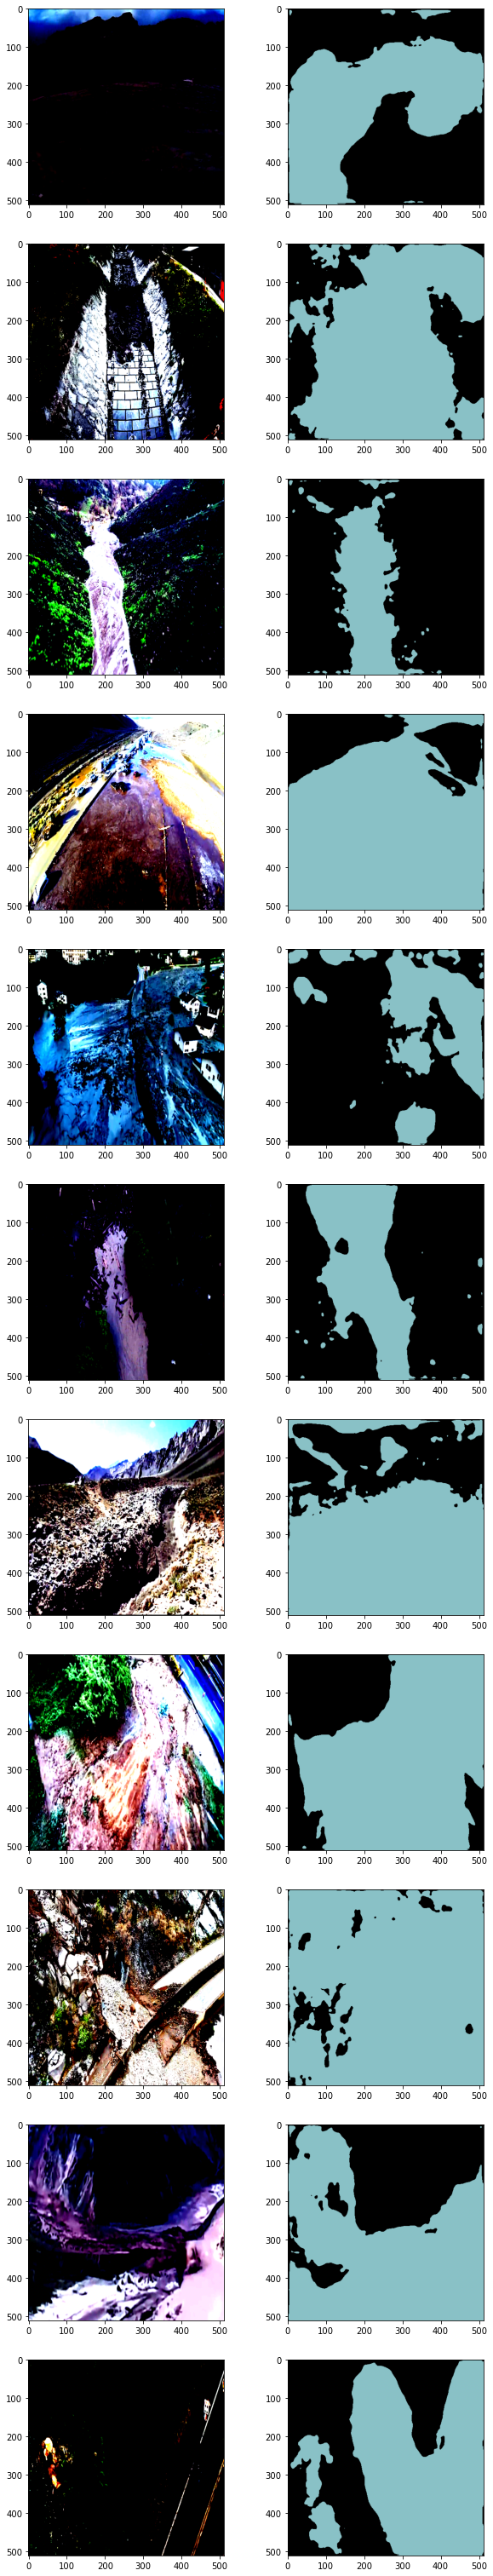

In [5]:
from PIL import Image

# debug
import matplotlib.pyplot as plt
n = len(test_dl)
fig, ax = plt.subplots(n, 2, figsize=(2*5, n*5))
imgs = []
# debug

model.eval()
with torch.no_grad():
    preds = []
    for i, x in enumerate(test_dl):
        x = x.to(device)
        y_pred = model(x)
        preds.append(y_pred.squeeze().permute(1,2,0).cpu().detach().numpy())

        imgs.append(x.squeeze().permute(1,2,0).cpu().numpy())

    preds = np.array(preds)

for i, mask_pred in enumerate(preds):
    print(f'saving predicted mask #{i}')

    mask_pred = np.argmax(mask_pred, axis=2)

    ax[i][0].imshow(imgs[i])
    ax[i][1].imshow(annotate_classes(mask_pred))

    # mask_path = os.path.join(
    #     args['output_dir'], f'{utils.convert_number_to_4_digits_str(i)}.png'
    # )

    # img = Image.fromarray(mask_pred.astype(np.uint8))
    # img.save(mask_path)


In [5]:
del imgs, preds

NameError: name 'imgs' is not defined

In [ ]:
# show predicted masks

n = len(os.listdir(args['output_dir']))
fig, ax = plt.subplots(n,2, figsize=(2*5, n*5))
for i, (img_name, mask_name) in enumerate(zip(os.listdir(args['input_dir']), os.listdir(args['output_dir']))):
    img_path = os.path.join(args['input_dir'], img_name)
    mask_path = os.path.join(args['output_dir'], mask_name)

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    ax[i][0].imshow(img)
    ax[i][1].imshow(annotate_classes(mask))

